In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


In [2]:
kbo_batting_all = pd.read_csv("kbobattingdata.csv")
kbo_pitching_all = pd.read_csv("kbopitchingdata.csv")
mlb_pitching_all = pd.read_csv("mlbpitching.csv")

### 데이터 전처리

In [3]:
mlb_pitching_all.drop(index=mlb_pitching_all[mlb_pitching_all['year'] < 2001].index, inplace=True)
kbo_pitching_all.drop(index=kbo_pitching_all[kbo_pitching_all['year'] < 2001].index, inplace=True)
kbo_batting_all.drop(index=kbo_batting_all[kbo_batting_all['year'] < 2001].index, inplace=True)

In [4]:
kbo_pitching_all['win_ratio'] = (kbo_pitching_all['wins'] / (kbo_pitching_all['wins'] + kbo_pitching_all['losses'])).round(3)

In [5]:
kbo_batting_all = pd.merge(kbo_batting_all, kbo_pitching_all[['year', 'team', 'win_ratio']], on=['year', 'team'])

In [6]:
kbo_batting_all['base_on_balls_per_game'] = kbo_batting_all['bases_on_balls'] / kbo_batting_all['games']

In [7]:
kbo_batting_all['RBI_per_game'] = kbo_batting_all['RBI'] / kbo_batting_all['games']

### EDA

<AxesSubplot:>

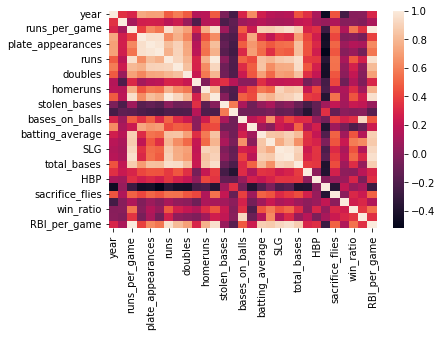

In [8]:
sns.heatmap(kbo_batting_all.corr())

<AxesSubplot:>

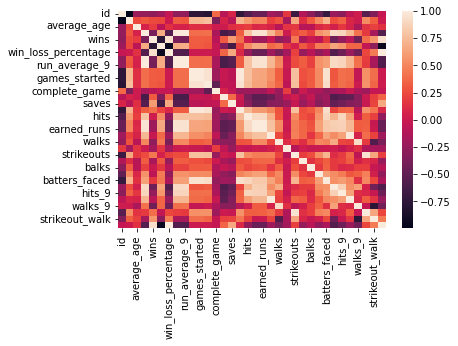

In [9]:
sns.heatmap(kbo_pitching_all.corr())

<AxesSubplot:>

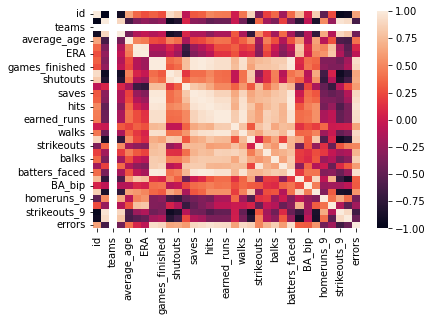

In [10]:
sns.heatmap(mlb_pitching_all.corr())

In [11]:
kbo_pitching_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   184 non-null    int64  
 1   year                 184 non-null    int64  
 2   team                 184 non-null    object 
 3   average_age          184 non-null    float64
 4   runs_per_game        184 non-null    float64
 5   wins                 184 non-null    int64  
 6   losses               184 non-null    int64  
 7   win_loss_percentage  184 non-null    float64
 8   ERA                  184 non-null    float64
 9   run_average_9        184 non-null    float64
 10  games                184 non-null    int64  
 11  games_started        184 non-null    float64
 12  games_finished       184 non-null    float64
 13  complete_game        184 non-null    int64  
 14  shutouts             184 non-null    int64  
 15  saves                184 non-null    int

### 상관성 확인되는 변수들 : 투수

d:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.6556670424946696, 5.535330147179407e-24)

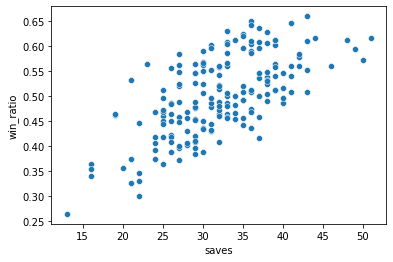

In [12]:
sns.scatterplot(kbo_pitching_all['saves'], kbo_pitching_all['win_ratio'])
stats.pearsonr(kbo_pitching_all['saves'], kbo_pitching_all['win_ratio'])

d:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-0.43858101819865586, 4.753368579172692e-10)

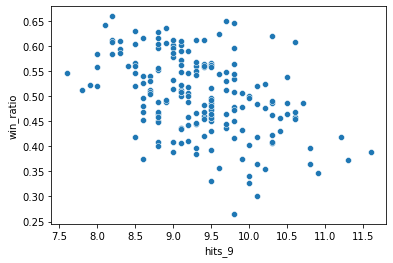

In [13]:
sns.scatterplot(kbo_pitching_all['hits_9'], kbo_pitching_all['win_ratio'])
stats.pearsonr(kbo_pitching_all['hits_9'], kbo_pitching_all['win_ratio'])

d:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-0.4199438605329169, 2.9523006090543016e-09)

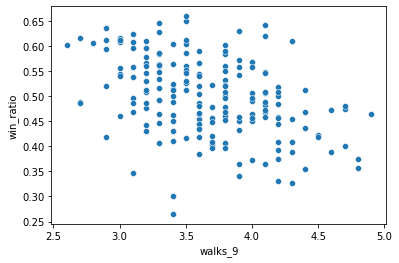

In [14]:
sns.scatterplot(kbo_pitching_all['walks_9'], kbo_pitching_all['win_ratio'])
stats.pearsonr(kbo_pitching_all['walks_9'], kbo_pitching_all['win_ratio'])

### 회귀 분석 및 모델 평가

In [28]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

res = smf.ols(formula='win_ratio ~ saves', data=kbo_pitching_all).fit()
print(res.summary())
table=sm.stats.anova_lm(res)
print(table)

                            OLS Regression Results                            
Dep. Variable:              win_ratio   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     137.2
Date:                Tue, 08 Nov 2022   Prob (F-statistic):           5.54e-24
Time:                        22:08:45   Log-Likelihood:                 259.00
No. Observations:                 184   AIC:                            -514.0
Df Residuals:                     182   BIC:                            -507.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2542      0.021     11.853      0.0

In [29]:
import statsmodels.api as sm

# crim, rm, lstat을 통한 다중 선형회귀분석
x_data = kbo_pitching_all[["saves", "hits_9", "walks_9", "strikeouts_9"]] #변수 여러개
target = kbo_pitching_all['win_ratio']

# for b0, 상수항 추가
x_data1 = sm.add_constant(x_data, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(target, x_data1)
fitted_multi_model = multi_model.fit()
print(fitted_multi_model.summary())

from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(multi_model.exog, i)} 
             for i, column in enumerate(multi_model.exog_names)
             if column != 'const')

                            OLS Regression Results                            
Dep. Variable:              win_ratio   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     61.94
Date:                Tue, 08 Nov 2022   Prob (F-statistic):           8.94e-33
Time:                        22:08:45   Log-Likelihood:                 287.23
No. Observations:                 184   AIC:                            -564.5
Df Residuals:                     179   BIC:                            -548.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.5022      0.082      6.156   

,컬럼,VIF
0,saves,1.316082
1,hits_9,1.215237
2,walks_9,1.108225
3,strikeouts_9,1.009438


In [30]:
fitted = res.predict(kbo_pitching_all)
residual = kbo_pitching_all['win_ratio'] - fitted

d:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ShapiroResult(statistic=0.9668112993240356, pvalue=0.00023348025570157915)

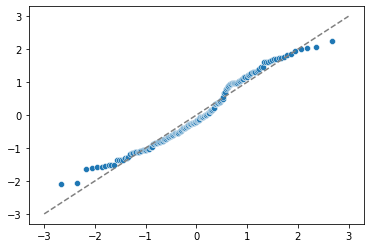

In [31]:
# 정규성 검정

import scipy.stats
sr = scipy.stats.zscore(residual)
(x, y), _ = scipy.stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')
scipy.stats.shapiro(residual)

d:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

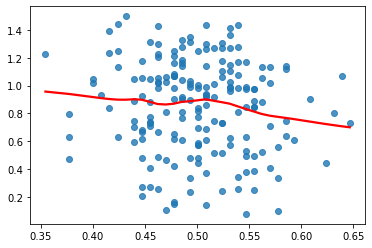

In [32]:
# 등분산성

import numpy as np

sns.regplot(fitted, np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})

### 관련성 떨어짐

d:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-0.20300994819885854, 0.0057126542000058645)

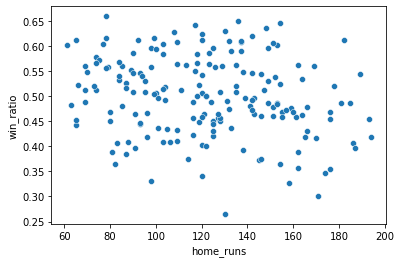

In [33]:
sns.scatterplot(kbo_pitching_all['home_runs'], kbo_pitching_all['win_ratio'])
stats.pearsonr(kbo_pitching_all['home_runs'], kbo_pitching_all['win_ratio'])

### 상관성 확인되는 변수들 : 타자

d:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.3620419564013434, 4.420940353348505e-07)

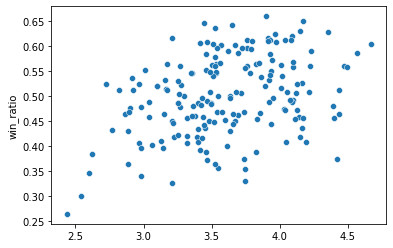

In [35]:
sns.scatterplot(kbo_batting_all['bases_on_balls'] / kbo_batting_all['games'], kbo_batting_all['win_ratio'])
stats.pearsonr(kbo_batting_all['bases_on_balls'] / kbo_batting_all['games'], kbo_batting_all['win_ratio'])

### 회귀 분석

In [41]:
import statsmodels.api as sm

# crim, rm, lstat을 통한 다중 선형회귀분석
x_data = kbo_batting_all[["base_on_balls_per_game", "RBI_per_game"]] #변수 여러개
target = kbo_batting_all['win_ratio']

# for b0, 상수항 추가
x_data1 = sm.add_constant(x_data, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(target, x_data1)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              win_ratio   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     45.47
Date:                Tue, 08 Nov 2022   Prob (F-statistic):           1.00e-16
Time:                        22:10:31   Log-Likelihood:                 244.75
No. Observations:                 184   AIC:                            -483.5
Df Residuals:                     181   BIC:                            -473.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1037      0.045      2.308      0.022       0.015       0.192
base_on_balls_per_game     0.0354      0.011      3.091      0.002       0.013       0.058
RBI_per_game               0.0585      0.008      7.436      0.000       0.043       0.074
==============================================================================
Omnibus:                        5.532   Durbin-Watson:                   1.699
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                3.044
Skew:                           0.015   Prob(JB):                        0.218
Kurtosis:                       2.371   Cond. No.                         57.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 관련성 떨어짐

d:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.22889939326039643, 0.0017757295963917355)

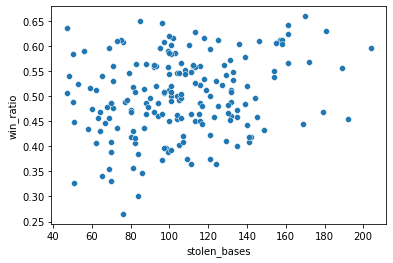

In [38]:
sns.scatterplot(kbo_batting_all['stolen_bases'], kbo_batting_all['win_ratio'])
stats.pearsonr(kbo_batting_all['stolen_bases'], kbo_batting_all['win_ratio'])

d:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.2711928398984327, 0.00019640648221235668)

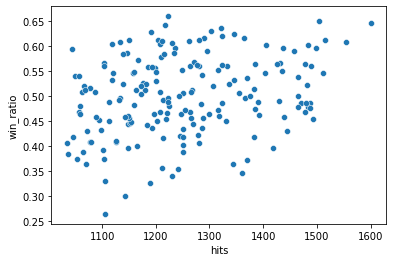

In [39]:
sns.scatterplot(kbo_batting_all['hits'], kbo_batting_all['win_ratio'])
stats.pearsonr(kbo_batting_all['hits'], kbo_batting_all['win_ratio'])

d:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0026905839968656598, 0.9710844508929917)

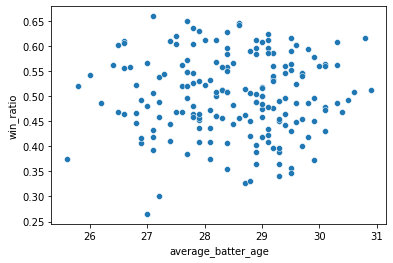

In [40]:
sns.scatterplot(kbo_batting_all['average_batter_age'], kbo_batting_all['win_ratio'])
stats.pearsonr(kbo_batting_all['average_batter_age'], kbo_batting_all['win_ratio'])